### Imports & Configs

In [1]:
import torch
import torch.nn as NN
import torchvision

from torch.utils.data import Dataset, DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import RandomResizedCrop, RandomHorizontalFlip, ColorJitter, RandomGrayscale, Compose, GaussianBlur, ToTensor, RandomApply

import torchvision.models as models

import os
import glob
import time
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm

D:\Python\pytorch\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)

1.13.1+cu117


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### SimCLR is based out of the following simplified modules:

* A stochastic data augmentation module.
* A neural network base encoder  f(.)
* A neural network projection head  g(.)
* A contrastive loss function.

### Stochastic Augmentation

* Author suggest that composition of data augmentation operations is crucial for learning good representations.
* Contrastive learning needs stronger data augmentation than supervised learning


In [4]:
def complete_image_transform(output_shape, kernel_size, s=1.0):
    """
    This method will transform the image as suggested by author
    - Random Crop with Resize
    - Random Horizontal Flip with 50% probability
    - Random Color Distortion
       - Random Color Jitter with 80% probability
       - Random Color Drop with 20% probability
    - Random Gaussian Blur with 50% probability
    
    s = filter strength paramter 
    """
    random_crop = RandomResizedCrop(output_shape)
    random_flip = RandomHorizontalFlip(p=0.5)
    
    color_jitter = ColorJitter(brightness=0.8*s, contrast=0.8*s, saturation=0.8*s, hue=0.2*s)
    random_color_jitter = RandomApply([color_jitter], p=0.8)
    
    random_gray = RandomGrayscale(p=0.2)
    gaussian_blur = GaussianBlur(kernel_size=kernel_size)
    random_gaussian_blur = RandomApply([gaussian_blur], p=0.5)
    
    to_tensor = ToTensor()
    
    image_transform = Compose([
        to_tensor,
        random_crop,
        random_flip,
        random_color_jitter,
        random_gray,
        random_gaussian_blur        
    ])
    return image_transform
    
class ContrastiveLearningViewGenerator(object):
    def __init__(self, base_transform, n_views = 2):
        self.base_transform = base_transform
        self.n_views = n_views
        
    def __call__(self, x):
        views = [self.base_transform(x) for i in range(self.n_views)]
        return views

### Prepare Data

* _torch.utils.data_ is the main class which help us in loading the data and iterating over it
* **torch.utils.data.DataSet** -> helps encapsulating raw data
* **torch.utils.data.DataLoader** -> helps iterating over the dataset

In [5]:
class BuildCustomData(Dataset):
    def __init__(self, list_images, transform=None):
        self.list_images = list_images
        self.transform = transform
        
    def __len__(self):
        return len(self.list_images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_name = self.list_images[idx]
        image = io.imread(image_name)
        if self.transform:
            image = self.transform(image)
            
        return image

In [6]:
# the size of images 
output_shape = [224, 224] # as we use standard Inception-style random cropping we will use 224 x 224 image to transform and random crop
kernel_size = [21,21] # We blur the image 50% of the time using a Gaussian kernel. The kernel size is set to be 10% of the image height/width.

# custom transformation of images (calling method above)

base_transform = complete_image_transform(output_shape=output_shape, kernel_size=kernel_size, s=1.0)

custom_transform = ContrastiveLearningViewGenerator(base_transform=base_transform)
list_images = glob.glob("../data/flowers/*/*.jpg")
flowers_dataset = BuildCustomData(list_images= list_images, transform=custom_transform)

In [7]:
print("total images in the dataset:",len(flowers_dataset))

total images in the dataset: 4317


C:\Users\adity\AppData\Local\Temp\ipykernel_19768\20202179.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,2,2*i)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


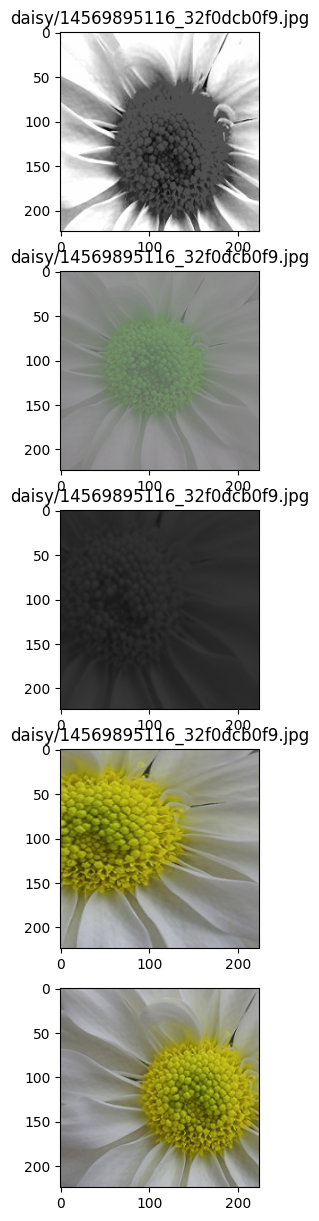

In [8]:
plt.figure(figsize=(25, 15))
def visualize_image(flowers, index):
    for i in range(1,6):
        images = flowers[index]
        v1, v2 = images
        plt.title("/".join(list_images[100].split("\\")[-2:]))
        plt.imshow(v1.permute(1,2,0))
        plt.subplot(5,2,2*i)
        plt.imshow(v2.permute(1,2,0))
        
visualize_image(flowers_dataset, 0) 

### Building the data loader

* References
    1. https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
    2. https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html

### Building SimCLR Model

* __Projection head:__ The authors use a small neural network projection head to map the representations to the space where the contrastive loss is applied. This helps to improve the discriminative power of the representations.

* __Contrastive loss:__ The authors use a contrastive loss function to train the model. This loss function encourages the model to learn representations that are similar for images that are semantically similar, and dissimilar for images that are semantically dissimilar.

* __Batch size and training steps:__ The authors found that larger batch sizes and more training steps led to better performance. This is because contrastive learning is a more data-intensive task than supervised learning.

## Contrastive Loss

* This has 2 functions in it:
    * Softmax
    * Cosine Similarity
---    
* _The neural network is first trained to project images into a lower-dimensional space. This is done by minimizing the loss function, which is the difference between the predicted probability distribution and the actual distribution._

* _Once the neural network is trained, it can be used to compute the cosine similarity between pairs of images. The cosine similarity is a measure of how similar two vectors are. It is calculated by taking the dot product of the two vectors and then dividing by the product of their norms._

* _The softmax function is then used to output a probability distribution for each pair of images. The softmax function takes a vector of numbers and outputs a list of numbers that sum to 1. Each number in the list represents the probability that the image belongs to a particular class._

* _The cross entropy loss function is then used to train the model to produce probability distributions that are peaked on the positive pairs._

* _The cross entropy loss is a measure of how different the predicted probability distribution is from the actual distribution. It is calculated by taking the sum of the logarithms of the predicted probabilities for the positive pairs._

In [10]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

Global seed set to 200


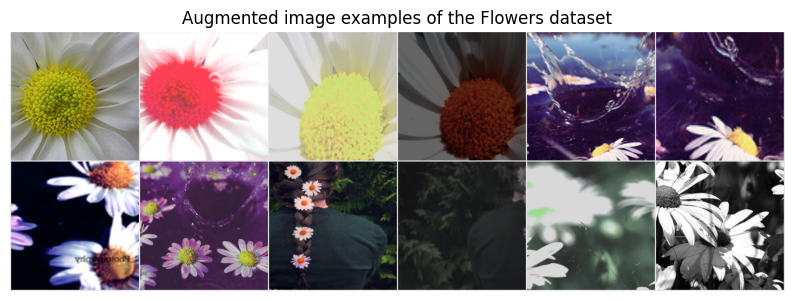

In [14]:
pl.seed_everything(200)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in flowers_dataset[idx]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the Flowers dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### SimCLR Implementation

In this comman experiment we will use ResNet-18 architecture. A neural network base encoder f() that extracts representation vectors from augmented data examples. 
Our framework allows various choices of the network architecture without any constraints. We opt for simplicity and adopt the commonly used ResNet to obtain _hi = f(\~xi) = ResNet(~xi)_ where _hi 2 Rd_ is the output after the average pooling layer.

The projection head _g(.)_ maps the representation _h_ into a space where we apply the contrastive loss, i.e., compare similarities between vectors. It is often chosen to be a small MLP with non-linearities, and for simplicity, we follow the original SimCLR paper setup by defining it as a two-layer MLP with ReLU activation in the hidden layer.

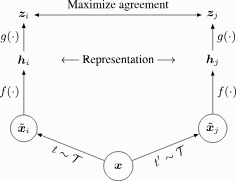! 

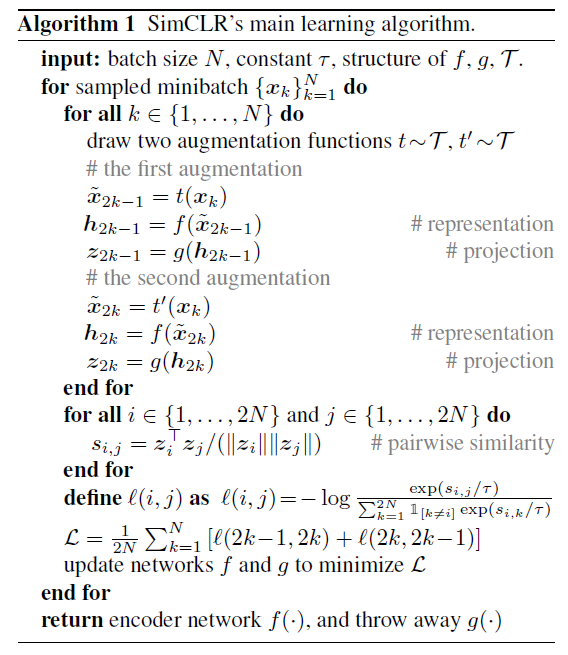


In [ ]:
class SimCLR(pl.LightningDataModule):
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        
        ## TODO: Define Base Model f(.) 
        ## MLP g(.)
        
    def configure_optimizers(self):
        ## used of optimized along with cosine similarity 
        pass
    
    def info_nce_loss(self, batch, mode='train'):
        ## batch encoding of all images
        ## Adding (ranking metrics for ) accuracy and loss for top1 and top5 
        pass
    
    def training_step(self, batch, batch_idx):
        pass
    
    def validation_step(self, batch, batch_idx):
        pass


### Traning the model